In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import tensorflow_hub as hub
from tensorflow_examples.models.pix2pix import pix2pix
import cv2


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [3]:
data = pd.read_csv("/kaggle/input/severstal-steel-defect-detection/train.csv")
train_images = np.array(os.listdir("/kaggle/input/severstal-steel-defect-detection/train_images"))
sub = pd.read_csv("/kaggle/input/severstal-steel-defect-detection/sample_submission.csv")

In [4]:
data.head(6)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
5,0025bde0c.jpg,3,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...


In [5]:
no_defect_images = train_images.tolist()
defect_set = set(data["ImageId"])

print(no_defect_images[:3])

for defect_images in defect_set:
    #print(defect_images)
    no_defect_images.remove(defect_images)
    
print(len(no_defect_images))

['74c8a2d5a.jpg', '0d617d477.jpg', '66e6c8a78.jpg']
5902


In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_maska

216


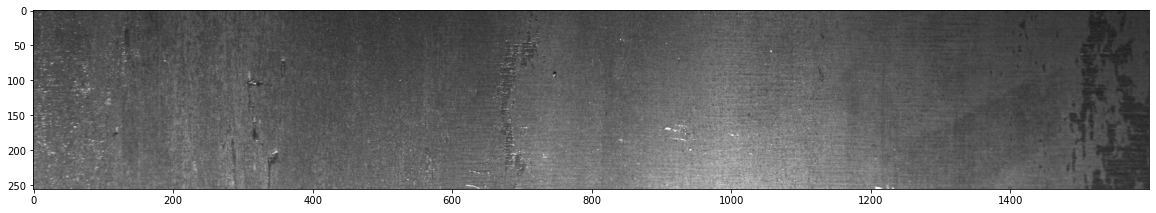

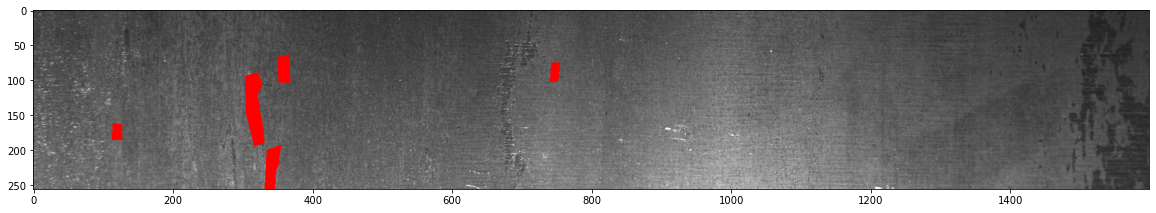

In [7]:
filename = data["ImageId"][0]
defect = data["EncodedPixels"][0].split(" ")
classId = data["ClassId"][0]
path = os.path.join("/kaggle/input/severstal-steel-defect-detection/train_images", filename)

bits = tf.io.read_file(path)
image = tf.image.decode_jpeg(bits, channels=3)
image = image.numpy()
plt.figure(figsize=(20,10))
plt.imshow(image)
print(len(defect))
for defect_index in range(0, len(defect), 2):
    #print("defect index: ", defect_index)
    for line in range(int(defect[defect_index+1])):
        row = int(int(defect[defect_index]) % 256)
        col = int(int(defect[defect_index]) / 256)
        #print("replace image", row + line, col, "defect line: ", line)
        if row + line > 255:
            continue
        image[row+line][col] = (255,0,0)

plt.figure(figsize=(20,10))
plt.imshow(image)

In [8]:
image.shape

(256, 1600, 3)

In [9]:
def rle_to_mask(rle, shape=(1600,256)):
    '''
    params:  rle   - run-length encoding string (pairs of start & length of encoding)
             shape - (width,height) of numpy array to return 
    
    returns: numpy array with dimensions of shape parameter
    '''    
    # the incoming string is space-delimited
    runs = np.asarray([int(run) for run in rle.split(' ')])
    
    # we do the same operation with the even and uneven elements, but this time with addition
    runs[1::2] += runs[0::2]
    # pixel numbers start at 1, indexes start at 0
    runs -= 1
    
    # extract the starting and ending indeces at even and uneven intervals, respectively
    run_starts, run_ends = runs[0::2], runs[1::2]
    
    # build the mask
    h, w = shape
    mask = np.zeros(h*w, dtype=np.uint8)
    for start, end in zip(run_starts, run_ends):
        mask[start:end] = 1
    
    # transform the numpy array from flat to the original image shape
    # from public notebook by robinteuwens/mask-rcnn-detailed-starter-code
    return mask.reshape(shape)

In [10]:
mask = rle_to_mask(data["EncodedPixels"][0])

In [11]:
squashed = data.dropna(subset=['EncodedPixels'], axis='rows', inplace=True)

# squash multiple rows per image into a list
squashed = data[['ImageId', 'EncodedPixels', 'ClassId']] \
            .groupby('ImageId', as_index=False) \
            .agg(list) \

# count the amount of class labels per image
squashed['Distinct Defect Types'] = squashed.ClassId.apply(lambda x: len(x))
squashed.head(6)

,ImageId,EncodedPixels,ClassId,Distinct Defect Types
0,0002cc93b.jpg,[29102 12 29346 24 29602 24 29858 24 30114 24 ...,[1],1
1,0007a71bf.jpg,[18661 28 18863 82 19091 110 19347 110 19603 1...,[3],1
2,000a4bcdd.jpg,[37607 3 37858 8 38108 14 38359 20 38610 25 38...,[1],1
3,000f6bf48.jpg,[131973 1 132228 4 132483 6 132738 8 132993 11...,[4],1
4,0014fce06.jpg,[229501 11 229741 33 229981 55 230221 77 23046...,[3],1
5,0025bde0c.jpg,[8458 14 8707 35 8963 48 9219 71 9475 88 9731 ...,"[3, 4]",2


In [12]:
from sklearn.model_selection import train_test_split

# stratified split to maintain the same class balance in both sets
train, validate = train_test_split(squashed, test_size=0.2, random_state=16)

In [13]:
print(train["EncodedPixels"][0])
mask = rle_to_mask(" ".join(train["EncodedPixels"][0]))
print(mask.shape)

['29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53 89283 40 89539 32 89667 10 89795 30 89923 28 90050 29 90179 37 90306 27 90434 38 90562 14 90690 38 90817 9 90946 38 91073 3 91202 38 91458 38 91714 38 91969 39 92225 39 92481 39 92737 39 92993 39 93248 40 93504 40 93760 40 94026 30 94302 10 189792 7 190034 21 190283 28 190539 28 190795 28 191051 28 191307 28 191563 28 191819 28 192075 28 192331 28 192587 28 192843 23 193099 14 193355 5']
(1600, 256

/kaggle/input/severstal-steel-defect-detection/train_images/0002cc93b.jpg
0       /kaggle/input/severstal-steel-defect-detection...
1       /kaggle/input/severstal-steel-defect-detection...
2       /kaggle/input/severstal-steel-defect-detection...
3       /kaggle/input/severstal-steel-defect-detection...
4       /kaggle/input/severstal-steel-defect-detection...
                              ...                        
6661    /kaggle/input/severstal-steel-defect-detection...
6662    /kaggle/input/severstal-steel-defect-detection...
6663    /kaggle/input/severstal-steel-defect-detection...
6664    /kaggle/input/severstal-steel-defect-detection...
6665    /kaggle/input/severstal-steel-defect-detection...
Name: ImageId, Length: 6666, dtype: object
0       /kaggle/input/severstal-steel-defect-detection...
1       /kaggle/input/severstal-steel-defect-detection...
2       /kaggle/input/severstal-steel-defect-detection...
3       /kaggle/input/severstal-steel-defect-detection...
4       /kagg

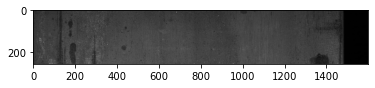

In [14]:
filename = squashed["ImageId"]

#path = os.path.join("/kaggle/input/severstal-steel-defect-detection/train_images", filename)

print(path)
print("/kaggle/input/severstal-steel-defect-detection/train_images/"+ filename)
paths = "/kaggle/input/severstal-steel-defect-detection/train_images/"+ filename
print(paths)

for pa in paths:
    
    img = cv2.imread(pa)

plt.imshow(img)


In [15]:
def keras_generator(batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):            
            fn = squashed["ImageId"]
            img = cv2.imread( '../input/severstal-steel-defect-detection/train_images/' + fn)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            
            mask = rle2mask(df_train['EncodedPixels'].iloc[i], img.shape)
            
            img = cv2.resize(img, (img_size, img_size))
            mask = cv2.resize(mask, (img_size, img_size))
            
            x_batch += [img]
            y_batch += [mask]
                                    
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [16]:
for x, y in keras_generator(4):
    break
    
print(x.shape, y.shape)

SystemError: <built-in function imread> returned NULL without setting an error

In [17]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [18]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(output_channels, 3, 
                                           strides=2,padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [19]:
def build_model():
    

SyntaxError: unexpected EOF while parsing (<ipython-input-19-aaf8983e2553>, line 2)

In [20]:
def train(model):
    """Train the model."""
    
    dataset_train = SeverstalDataset(train)
    dataset_train.load_dataset() # load pics from train
    dataset_train.prepare()

    # Validation dataset
    dataset_val = SeverstalDataset(validate)
    dataset_val.load_dataset() # load pics from train
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=15,
                layers='heads')  
    
#     model.save('64x3-CNN.model')

# checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')) #


In [21]:
sub.EncodedPixels = ""
sub.to_csv("submission.csv",  index = False)